# FINN - End-to-End Flow
-----------------------------------------------------------------

In this notebook, we will show how to take a simple, binarized, fully-connected network trained on the MNIST data set and take it all the way down to a customized bitfile running on a PYNQ board. 

This notebook is quite lengthy, and some of the cells (involving Vivado synthesis) may take up to an hour to finish running. To let you save and resume your progress, we will save the intermediate ONNX models that are generated in the various steps to disk, so that you can jump back directly to where you left off.



## Overview

The FINN compiler comes with many *transformations* that modify the ONNX representation of the network according to certain patterns. This notebook will demonstrate a *possible* sequence of such transformations to take a particular trained network all the way down to hardware, as shown in the figure below.

![](finn-design-flow-example.svg)

The white fields show the state of the network representation in the respective step. The colored fields represent the transformations that are applied to the network to achieve a certain result. The diagram is divided into 5 sections represented by a different color, each of it includes several flow steps. The flow starts in top left corner with Brevitas export (green section), followed by the preparation of the network (blue section) for the Vivado HLS synthesis and Vivado IPI stitching (orange section), and finally building a PYNQ overlay bitfile and testing it on a PYNQ board (yellow section).
There is an additional section for functional verification (red section) on the left side of the diagram, which we will not cover in this notebook. For details please take a look in the verification notebook which you can find [here](tfc_end2end_verification.ipynb)


This Jupyter notebook is organized based on the sections described above. We will use the following helper functions, `showSrc` to show source code of FINN library calls and `showInNetron` to show the ONNX model at the current transformation step. The Netron displays are interactive, but they only work when running the notebook actively and not on GitHub (i.e. if you are viewing this on GitHub you'll only see blank squares).

In [1]:
import inspect
import netron
from finn.util.basic import make_build_dir
from IPython.display import IFrame

def showSrc(what):
    print("".join(inspect.getsourcelines(what)[0]))
    
def showInNetron(model_filename):
    netron.start(model_filename, port=8081, host="0.0.0.0")
    return IFrame(src="http://0.0.0.0:8081/", width="100%", height=400)
    
build_dir = "/workspace/finn"

## Outline
-------------
1. [Brevitas export](#brev_exp)
2. [Network preparation](#nw_prep)
3. [Vivado HLS and IPI](#vivado)
4. [PYNQ hardware generation and deployment](#hw_test)

## 1. Brevitas export <a id='brev_exp'></a>
FINN expects an ONNX model as input. This can be a model trained with [Brevitas](https://github.com/Xilinx/brevitas). Brevitas is a PyTorch library for quantization-aware training and the FINN Docker image comes with several [example Brevitas networks](https://github.com/maltanar/brevitas_cnv_lfc). To show the FINN end-to-end flow, we'll use the TFC-w1a1 model as example network.

First a few things have to be imported. Then the model can be loaded with the pretrained weights.

In [2]:
import onnx
from finn.util.test import get_test_model_trained
import brevitas.onnx as bo

tfc = get_test_model_trained("TFC", 1, 1)
bo.export_finn_onnx(tfc, (1, 1, 28, 28), build_dir+"/tfc_w1_a1.onnx")

/workspace/brevitas_cnv_lfc/training_scripts/models/TFC.py:85: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  x = 2.0 * x - torch.tensor([1.0]).to(self.device)


The model was now exported, loaded with the pretrained weights and saved under the name "lfc_w1_a1.onnx".
To visualize the exported model, Netron can be used. Netron is a visualizer for neural networks and allows interactive investigation of network properties. For example, you can click on the individual nodes and view the properties.

In [3]:
showInNetron(build_dir+"/tfc_w1_a1.onnx")

Serving '/workspace/finn/tfc_w1_a1.onnx' at http://0.0.0.0:8081


Now that we have the model in .onnx format, we can work with it using FINN. For that FINN `ModelWrapper` is used. It is a wrapper around the ONNX model which provides several helper functions to make it easier to work with the model.

In [4]:
from finn.core.modelwrapper import ModelWrapper
model = ModelWrapper(build_dir+"/tfc_w1_a1.onnx")

Now the model is prepared and could be simulated using Python. How this works is described in subsection [Simulation using Python](#simpy) in the section about *Simulation & Emulation Flows*.

The model can now also be processed in different ways. The principle of FINN are analysis and transformation passes, which can be applied to the model. An analysis pass extracts specific information about the model and returns it to the user in the form of a dictionary. A transformation pass changes the model and returns the changed model back to the FINN flow.

Since the goal in this notebook is to process the model to such an extent that a bitstream can be generated from it, the focus is on the transformations that are necessary for this. In the next section these are discussed in more detail.

## 2. Network preparation <a id='nw_prep'></a>

* [Tidy-up transformations](#basic_trafo)
* [Streamlining](#streamline)
* [Conversion to HLS layers](#hls_layers)
* [Folding](#folding)


In this section, we will put the network through a series of transformations that puts it in a form that can be stitched together to form a FINN-style dataflow architecture, yielding a high-performance, high-efficiency FPGA accelerator.

### FINN-style Dataflow Architectures

We start with a quick recap of FINN-style dataflow architectures. The key idea in such architectures is to parallelize across layers as well as within layers by dedicating a proportionate amount of compute resources to each layer, as illustrated in the figure below taken from the [FINN-R paper](https://arxiv.org/pdf/1809.04570.pdf):

![](finn-hw-arch.png)

In practice, the compute arrays are instantiated by function calls to optimized Vivado HLS building blocks from the [finn-hlslib](https://github.com/Xilinx/finn-hlslib) library. As these function calls can only handle certain patterns/cases, we need to transform the network into an appropriate form so that we can replace network layers with these function calls, which is the goal of the network preparation process.

### Tidy-up transformations <a id='basic_trafo'></a>
This section deals with some basic transformations, which are applied to the model like a kind of "tidy-up" to make it easier to be processed. They do not appear in the diagram above, but they are applied in many steps in the FINN flow to postprocess the model after a transformation and/or to prepare it for the next transformation.

These transformations are:
* GiveUniqueNodeNames
* GiveReadableTensorNames
* InferShapes
* InferDataTypes
* FoldConstants

In the first two transformations (`GiveUniqueNodeNames`, `GiveReadableTensorNames`) the nodes in the graph are first given unique (by enumeration) names, then the tensors are given human-readable names (based on the node names). The following two transformations (`InferShapes`, `InferDataTypes`) derive the shapes and data types of the tensors from the model properties and set them in the `ValueInfo` of the model. These transformations can almost always be applied without negative effects and do not affect the structure of the graph, ensuring that all the information needed is available.

The last listed transformation is `FoldConstants`, which performs constant folding. It identifies a node with constant inputs and determines its output. The result is then set as constant-only inputs for the following node and the old node is removed. Although this transformation changes the structure of the model, it is a transformation that is usually always desired and can be applied to any model.

These transformations can be imported and applied as follows.

In [5]:
from finn.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames
from finn.transformation.infer_shapes import InferShapes
from finn.transformation.infer_datatypes import InferDataTypes
from finn.transformation.fold_constants import FoldConstants

model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())

model.save(build_dir+"/tfc_w1_a1_tidy.onnx")

The result of these transformations can be viewed with netron after the model has been saved again. By clicking on the individual nodes, it can now be seen, for example, that each node has been given a name. Also the whole upper area could be folded, so that now the first node is "Reshape".

In [6]:
showInNetron(build_dir+"/tfc_w1_a1_tidy.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/tfc_w1_a1_tidy.onnx' at http://0.0.0.0:8081


### Streamlining <a id='streamline'></a>
Streamlining is a transformation containing several sub-transformations. The goal of streamlining is to eliminate floating point operations by moving them around, then collapsing them into one operation and in the last step transform them into multi-thresholding nodes. For more information on the theoretical background of this, see [this paper](https://arxiv.org/pdf/1709.04060).

Let's have a look at which sub-transformations `Streamline` consists of:

In [7]:
from finn.transformation.streamline import Streamline
showSrc(Streamline)

class Streamline(Transformation):
    """Apply the streamlining transform, see arXiv:1709.04060."""

    def apply(self, model):
        streamline_transformations = [
            ConvertSubToAdd(),
            ConvertDivToMul(),
            BatchNormToAffine(),
            ConvertSignToThres(),
            MoveAddPastMul(),
            MoveScalarAddPastMatMul(),
            MoveScalarAddPastConv(),
            MoveScalarMulPastMatMul(),
            MoveScalarMulPastConv(),
            MoveAddPastMul(),
            CollapseRepeatedAdd(),
            CollapseRepeatedMul(),
            AbsorbAddIntoMultiThreshold(),
            FactorOutMulSignMagnitude(),
            AbsorbMulIntoMultiThreshold(),
            Absorb1BitMulIntoMatMul(),
            Absorb1BitMulIntoConv(),
            RoundAndClipThresholds(),
        ]
        for trn in streamline_transformations:
            model = model.transform(trn)
            model = model.transform(GiveUniqueNodeNames())
            model = mod

As can be seen, several transformations are involved in the streamlining transformation. There are move and collapse transformations. In the last step the operations are transformed into multithresholds. The involved transformations can be viewed in detail [here](https://github.com/Xilinx/finn/tree/dev/src/finn/transformation/streamline). After each transformation, three of the tidy-up transformations (`GiveUniqueNodeNames`, `GiveReadableTensorNames` and `InferDataTypes`) are applied to the model.

After streamlining the network looks as follows:

In [8]:
model = ModelWrapper(build_dir+"/tfc_w1_a1_tidy.onnx")
model = model.transform(Streamline())
model.save(build_dir+"/tfc_w1_a1_streamlined.onnx")
showInNetron(build_dir+"/tfc_w1_a1_streamlined.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/tfc_w1_a1_streamlined.onnx' at http://0.0.0.0:8081


You can see that the network has become simplified considerably compared to the previous step -- a lot of nodes have disappeared between the `MatMul` layers, and the `Sign` nodes have been replaced with `MultiThreshold` nodes instead. 

**The current implementation of streamlining is highly network-specific and may not work for your network if its topology is very different than the example network here. We hope to rectify this in future releases.**

Our example network is a quantized network with 1-bit bipolar (-1, +1 values) precision, and we want FINN to implement them as XNOR-popcount operations [as described in the original FINN paper](https://arxiv.org/pdf/1612.07119). For this reason, after streamlining, the resulting bipolar matrix multiplications are converted into xnorpopcount operations. This transformation produces operations that are again collapsed and converted into thresholds. This procedure is shown below. 

In [9]:
from finn.transformation.bipolar_to_xnor import ConvertBipolarMatMulToXnorPopcount
import finn.transformation.streamline.absorb as absorb
from finn.transformation.streamline.round_thresholds import RoundAndClipThresholds

model = model.transform(ConvertBipolarMatMulToXnorPopcount())
model = model.transform(absorb.AbsorbAddIntoMultiThreshold())
model = model.transform(absorb.AbsorbMulIntoMultiThreshold())
model = model.transform(RoundAndClipThresholds())

model.save(build_dir+"/tfc_w1a1_ready_for_hls_conversion.onnx")
showInNetron(build_dir+"/tfc_w1a1_ready_for_hls_conversion.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/tfc_w1a1_ready_for_hls_conversion.onnx' at http://0.0.0.0:8081


Observe the pairs of `XnorPopcountmatMul` and `MultiThreshold` layers following each other -- this is the particular pattern that the next step will be looking for in order to convert them to HLS layers.

### Conversion to HLS layers <a id='hls_layers'></a>
Converts the nodes to HLS layers that correspond to the functions in [finn-hls library](https://finn-hlslib.readthedocs.io/en/latest/). In our case this transformation onverts pairs of binary XnorPopcountMatMul layers to StreamingFCLayer_Batch layers. Any immediately following MultiThreshold layers will also be absorbed into the MVTU.

Below is the code for the transformation and the network is visualized using netron to create the new structure with `StreamingFCLayer_Batch` nodes, which will correspond to a function call from the [finn-hlslib](https://finn-hlslib.readthedocs.io/en/latest/library/fclayer.html#_CPPv4I_j_j_j_j000_i_i000E22StreamingFCLayer_BatchvRN3hls6streamI7ap_uintI9InStreamWEEERN3hls6streamI7ap_uintI10OutStreamWEEERK2TWRK2TAKjRK1R) library.

In [10]:
import finn.transformation.fpgadataflow.convert_to_hls_layers as to_hls
model = ModelWrapper(build_dir+"/tfc_w1a1_ready_for_hls_conversion.onnx")
model = model.transform(to_hls.InferBinaryStreamingFCLayer())
model.save(build_dir+"/tfc_w1_a1_hls_layers.onnx")
showInNetron(build_dir+"/tfc_w1_a1_hls_layers.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/tfc_w1_a1_hls_layers.onnx' at http://0.0.0.0:8081


Each StreamingFCLayer_Batch node has two attributes that specify the degree of folding, PE and SIMD. In all nodes the values for these attributes are set as default to 1, which would correspond to a maximum folding (time multiplexing) and thus minimum performance. We will shortly cover how these can be adjusted, but first we want to separate the HLS layers from the non-HLS layers in this network.

### Creating a Dataflow Partition <a id='dataflow_partition'></a>

In the graph above, you can see that there is a mixture of FINN HLS layers (StreamingFCLayer_Batch) with regular ONNX layers (Reshape, Mul, Add). To create a bitstream, FINN needs a model with only HLS layers. In order to achieve this, we will use the `CreateDataflowPartition` transformation to create a "dataflow partition" in this graph, separating out the HLS layers into another model, and replacing them with a placeholder layer called StreamingDataflowPartition:

In [11]:
from finn.transformation.fpgadataflow.create_dataflow_partition import CreateDataflowPartition

model = ModelWrapper(build_dir+"/tfc_w1_a1_hls_layers.onnx")
parent_model = model.transform(CreateDataflowPartition())
parent_model.save(build_dir+"/tfc_w1_a1_dataflow_parent.onnx")
showInNetron(build_dir+"/tfc_w1_a1_dataflow_parent.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/tfc_w1_a1_dataflow_parent.onnx' at http://0.0.0.0:8081


We can see that the StreamingFCLayer instances have all been replaced with a single `StreamingDataflowPartition`, which has an attribute `model` that points to the extracted, HLS dataflow-only graph:

In [12]:
from finn.custom_op.registry import getCustomOp
sdp_node = getCustomOp(parent_model.graph.node[2])
dataflow_model_filename = sdp_node.get_nodeattr("model")
showInNetron(dataflow_model_filename)


Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_jakobap/dataflow_partition_dkjtsnwj/df_model.onnx' at http://0.0.0.0:8081


We can see all the extracted `StreamingFCLayer` instances have been moved to the child (dataflow) model. We will load the child model with `ModelWrapper` and continue working on it.

In [13]:
model = ModelWrapper(dataflow_model_filename)

### Folding and TLastMarker Insertion <a id='folding'></a>

*Folding* in FINN describes how much a layer is time-multiplexed in terms of execution resources. There are several *folding factors* for each layer, controlled by the PE (parallelization over outputs) and SIMD (parallelization over inputs) parameters as described by the original [FINN paper](https://arxiv.org/pdf/1612.07119). The higher the PE and SIMD values are set, the faster the generated accelerator will run, and the more FPGA resources it will consume. 

Since the folding parameters are node attributes, they can be easily accessed and changed using a helper function of the `ModelWrapper`. But first we have to extract the nodes which are StreamingFCLayer_Batch operations. This is where the Netron visualization helps us, in the above diagram we can see that the first four nodes are StreamingFCLayer_Batch. Through the `print`s we can check if the extracted nodes all have the op_type "StreamingFCLayer_Batch".

In [14]:
fc0 = model.graph.node[0]
fc1 = model.graph.node[1]
fc2 = model.graph.node[2]
fc3 = model.graph.node[3]
print("fc0 has the op_type: " + str(fc0.op_type))
print("fc1 has the op_type: " + str(fc1.op_type))
print("fc2 has the op_type: " + str(fc2.op_type))
print("fc3 has the op_type: " + str(fc3.op_type))

fc0 has the op_type: StreamingFCLayer_Batch
fc1 has the op_type: StreamingFCLayer_Batch
fc2 has the op_type: StreamingFCLayer_Batch
fc3 has the op_type: StreamingFCLayer_Batch


We can use the higher-level [HLSCustomOp](https://github.com/Xilinx/finn/blob/master/src/finn/custom_op/fpgadataflow/__init__.py) wrappers for these nodes. These wrappers provide easy access to specific properties of these nodes, such as the folding factors (PE and SIMD). Let's have a look at which node attributes are defined by the CustomOp wrapper, and adjust the SIMD and PE attributes.

In [15]:
fc0w = getCustomOp(fc0)
fc1w = getCustomOp(fc1)
fc2w = getCustomOp(fc2)
fc3w = getCustomOp(fc3)

print("CustomOp wrapper is of class " + fc0w.__class__.__name__)

fc0w.get_nodeattr_types()

CustomOp wrapper is of class StreamingFCLayer_Batch


{'PE': ('i', True, 0),
 'SIMD': ('i', True, 0),
 'MW': ('i', True, 0),
 'MH': ('i', True, 0),
 'resType': ('s', True, ''),
 'ActVal': ('i', False, 0),
 'inputDataType': ('s', True, ''),
 'weightDataType': ('s', True, ''),
 'outputDataType': ('s', True, ''),
 'binaryXnorMode': ('i', False, 0),
 'noActivation': ('i', False, 0),
 'numInputVectors': ('ints', False, [1]),
 'mem_mode': ('s', False, 'const'),
 'ram_style': ('s', False, 'auto'),
 'backend': ('s', True, 'fpgadataflow'),
 'code_gen_dir_npysim': ('s', False, ''),
 'code_gen_dir_ipgen': ('s', False, ''),
 'executable_path': ('s', False, ''),
 'ipgen_path': ('s', False, ''),
 'ip_path': ('s', False, ''),
 'ip_vlnv': ('s', False, ''),
 'exec_mode': ('s', False, ''),
 'sim_cycles': ('i', False, 0),
 'rtlsim_trace': ('s', False, ''),
 'res_estimate': ('s', False, ''),
 'res_hls': ('s', False, ''),
 'res_synth': ('s', False, ''),
 'rtlsim_so': ('s', False, ''),
 'inFIFODepth': ('i', False, 2),
 'outFIFODepth': ('i', False, 2)}

We can see that the PE and SIMD are listed as node attributes, as well as the depths of the FIFOs that will be inserted between consecutive layers, and all can be adjusted using `set_nodeattr` subject to certain constraints.
**In this notebook we are setting the folding factors and FIFO depths manually, but in a future version we will support determining the folding factors given an FPGA resource budget according to the analytical model from the [FINN-R paper](https://arxiv.org/pdf/1809.04570).**

In [16]:
# SIMD controls the folding over the input vector
# PE controls the folding over the output vector

fc0w.set_nodeattr("inFIFODepth", 50)
fc0w.set_nodeattr("SIMD", 16)
fc0w.set_nodeattr("PE", 16)
fc0w.set_nodeattr("outFIFODepth", 4)

fc1w.set_nodeattr("inFIFODepth", 4)
fc1w.set_nodeattr("SIMD", 16)
fc1w.set_nodeattr("PE", 16)
fc1w.set_nodeattr("outFIFODepth", 4)

fc2w.set_nodeattr("inFIFODepth", 4)
fc2w.set_nodeattr("SIMD", 16)
fc2w.set_nodeattr("PE", 16)
fc2w.set_nodeattr("outFIFODepth", 4)

fc3w.set_nodeattr("inFIFODepth", 4)
fc3w.set_nodeattr("SIMD", 16)
fc3w.set_nodeattr("PE", 10)
fc3w.set_nodeattr("outFIFODepth", 50)


After setting the FIFO node attributes, we can insert FIFO nodes inbetween the fpgadataflow nodes and in the beginning and end of the graph. This can be done using the transformation `InsertFIFO`.

In [17]:
from finn.transformation.fpgadataflow.insert_fifo import InsertFIFO
model = model.transform(InsertFIFO())

Finally, we will run the `InsertTLastMarker` transformation to get a `TLastMarker` node at the output of this graph, which is necessary to run the DMA engines correctly. Using netron we can observe that now the nodes contain the set folding, inbetween the nodes are FIFOs inserted and the last node is the `TLastMarker` node we insert in the following.

In [18]:
from finn.transformation.fpgadataflow.insert_tlastmarker import InsertTLastMarker
model = model.transform(InsertTLastMarker())
model.save(build_dir+"/tfc_w1_a1_set_folding_factors.onnx")
showInNetron(build_dir+"/tfc_w1_a1_set_folding_factors.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/tfc_w1_a1_set_folding_factors.onnx' at http://0.0.0.0:8081


This completes the network preparation and the network can be passed on to the next block *Vivado HLS and Vivado synthesis*, which is described below.

## 3. Vivado HLS and IPI <a id='vivado'></a>
* [Generating HLS Code](#hls_per_layer)
* [Synthesizing HLS to IP Blocks](#hls_synth)
* [IP Stitching](#ip_stitching)

As we will be dealing with FPGA synthesis tools in these tasks, we'll define two helper variables that describe the Xilinx FPGA part name and the PYNQ board name that we are targeting.

In [19]:
# print the names of the supported PYNQ boards
from finn.util.basic import pynq_part_map
print(pynq_part_map.keys())

dict_keys(['Ultra96', 'Pynq-Z1', 'Pynq-Z2', 'ZCU104'])


In [20]:
# change this if you have a different PYNQ board, see list above
pynq_board = "Ultra96"
fpga_part = pynq_part_map[pynq_board]
target_clk_ns = 5

### Generating HLS Code <a id='hls_per_layer'></a>
This section deals with the generation of an IP block from the different layers. These can then be stitched to a block design that corresponds to the complete model. The single conversion into IP blocks allows a good transparency and we can check the functionality of each IP block and compare it with the behaviour of the corresponding ONNX node. 

Two transformations are required to generate HLS IP blocks for each layer: 
* `CodeGen_ipgen` which generates the HLS C++ code for the node and a tcl-script which starts the HLS synthesis and exports the design as IP. 
* `HLSSynth_IPGen` which passes the tcl-script to Vivado HLS and thus performs the actual IP generation. 

We start off by giving unique node names using the basic transformation `GiveUniqueNodeNames`, and then proceed with the HLS C++ code generation with `CodeGen_ipgen`.

In [21]:
model = ModelWrapper(build_dir+"/tfc_w1_a1_set_folding_factors.onnx")
model = model.transform(GiveUniqueNodeNames())

from finn.transformation.fpgadataflow.codegen_ipgen import CodeGen_ipgen
model = model.transform(CodeGen_ipgen(fpga_part, target_clk_ns))

### Synthesizing HLS to IP Blocks <a id='hls_synth'></a>

Now that we have generated the HLS code for each layer, we can call the `HLSSynth_IPGen` transformation to convert the generated HLS into Vivado IP blocks. **As this involves calling HLS synthesis, this transformation will run for some time (several minutes).**

In [22]:
from finn.transformation.fpgadataflow.hlssynth_ipgen import HLSSynth_IPGen

model = model.transform(HLSSynth_IPGen())
model.save(build_dir+"/tfc_w1_a1_ipgen.onnx")

Each `StreamingFCLayer_Batch` node now has new attributes which can be examined more closely with netron.

In [23]:
showInNetron(build_dir+"/tfc_w1_a1_ipgen.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/tfc_w1_a1_ipgen.onnx' at http://0.0.0.0:8081


There are two additional attributes: 
* `code_gen_dir_ipgen` which contains the directory path where all the files generated by the ipgen transformations are stored
* `ipgen_path` which contains the path to the project directory in which the generated IP block is stored

We can further investigate which files are produced by taking a look in this directory. For example for the first StreamingFCLayer_Batch node.

In [24]:
fc0w = getCustomOp(model.graph.node[0])
code_gen_dir = fc0w.get_nodeattr("code_gen_dir_ipgen")
!ls {code_gen_dir}

project_StreamingFIFO_0


Directory *project_StreamingFCLayer_Batch_0* contains the project created by Vivado HLS into which the IP Block is exported, along with other files generated by Vivado HLS. If we compare it to the above visualization of the network with netron, this is exactly the name of the folder stored in the node attribute `ipgen_path`. The .cpp code that is passed to Vivado HLS can be found in the file *top_StreamingFCLayer_Batch_0.cpp*. The files *params.h* and *thresh.h* belong to that as well, they contain the values for the weights and thresholds. *vivado_hls.log* is the log file from Vivado HLS. Besides these files, the folder contains *ipgen.sh* and *hls_syn_StreamingFCLayer_Batch_0.tcl*. First we take a look at *ipgen.sh*.

In [25]:
shell_script = code_gen_dir + "/ipgen.sh"
!cat {shell_script}

cat: /tmp/finn_dev_jakobap/code_gen_ipgen_StreamingFIFO_0_ruu9s3g8/ipgen.sh: No such file or directory


The script consists only of two framing `cd` commands and a command to pass the tcl script to *vivado_hls*. The directory has to be changed to create the files in the correct folder and will then be changed back to the original directory. 

Below is the tcl script which is passed to *vivado_hls*.

In [26]:
tcl_script = code_gen_dir + "/hls_syn_StreamingFCLayer_Batch_0.tcl"
!cat {tcl_script}

cat: /tmp/finn_dev_jakobap/code_gen_ipgen_StreamingFIFO_0_ruu9s3g8/hls_syn_StreamingFCLayer_Batch_0.tcl: No such file or directory


In the first part of the script the project is configured. For example the FPGA part and the clock are set. Then the project is opened and the files are added. The toplevel function is set and after creating a clock, the design is first synthesized with `csynth` and then exported as an IP block.

Now that all IP blocks are in place, they can be stitched together to create an IP design that matches the ONNX model. This is covered in the next section.

### IP Stitching <a id='ip_stitching'></a>

We now have IP blocks for each of our layers, and will stitch them together into a larger IP that implements the whole network using the `CodeGen_ipstitch` transformation. Bear in mind that this transformation can only be applied on a graph that only contains HLS nodes that already have been through the `HLSSynth_IPGen` transformation, which is the last step we performed. Prior to calling IP stitching, we'll also use the `ReplaceVerilogRelPaths` transformation to convert any relative `$readmemh` paths in the generated IP blocks to absolute ones, which prevents errors later on. **This step invokes Vivado and may take a few minutes to run.**

In [27]:
from finn.transformation.fpgadataflow.codegen_ipstitch import CodeGen_ipstitch
from finn.transformation.fpgadataflow.replace_verilog_relpaths import ReplaceVerilogRelPaths
model = ModelWrapper(build_dir+"/tfc_w1_a1_ipgen.onnx")
model = model.transform(ReplaceVerilogRelPaths())
model = model.transform(CodeGen_ipstitch(fpga_part))

If you examine the nodes themselves on the transformed model you won't see a difference, because the IP stitching adds model-level metadata to the graph. This can be accessed using the `.model.metadata_props`, the `get_metadata_prop` function in `ModelWrapper`, or by clicking on the global input/output tensors in Netron.

In [28]:
model.model.metadata_props

[key: "vivado_stitch_proj"
value: "/tmp/finn_dev_jakobap/vivado_stitch_proj_b75moqdt"
, key: "vivado_stitch_vlnv"
value: "xilinx_finn:finn:finn_design:1.0"
, key: "wrapper_filename"
value: "/tmp/finn_dev_jakobap/vivado_stitch_proj_b75moqdt/finn_vivado_stitch_proj.srcs/sources_1/bd/finn_design/hdl/finn_design_wrapper.v"
]

In [29]:
model.get_metadata_prop("vivado_stitch_proj")

'/tmp/finn_dev_jakobap/vivado_stitch_proj_b75moqdt'

If you navigate to the folder above (remember the /tmp/finn_xxx folder is mounted on the host as well as inside Docker) you can open the Vivado project (.xpr) file there using Vivado, and view the following stitched IP block design:

![](stitched_ip.png)

In [30]:
model.save(build_dir+"/tfc_w1_a1_ipstitch.onnx")

At this point, one could take the generated stitched IP and integrate it into your own project using Vivado IP Integrator if desired. Here, we will continue the tutorial by assuming that we want to do a stand-alone deployment for this accelerator for a PYNQ board.

## 4.  PYNQ hardware generation and deployment <a id='hw_test'></a>

* [Inserting the IP into a PYNQ Overlay Shell](#pynq_shell)
* [Synthesis, place and route](#synth_pl_ro)
* [Driver Generation](#driver_gen)
* [Deployment and Remote Execution](#deploy)


We are almost done preparing our hardware design. We'll now put it in a form suitable for use as a PYNQ overlay, synthesize and deploy it.

### Inserting the IP into a PYNQ Overlay Shell <a id='pynq_shell'></a>

We are almost done preparing our hardware design. To deploy our accelerator on a PYNQ platform, it needs to be put inside an appropriate *shell* that bridges it with the interfaces that the underlying system exposes. FINN makes it easy to create a PYNQ-compatible overlay by inserting the stitched IP into an appropriate PYNQ shell with the `MakePYNQProject` transformation, and view the created PYNQ shell project directory using the `metadata_props`. **This invokes Vivado and may take a few minutes to run.**

In [31]:
from finn.transformation.fpgadataflow.make_pynq_proj import MakePYNQProject
model = ModelWrapper(build_dir+"/tfc_w1_a1_ipstitch.onnx")
model = model.transform(MakePYNQProject(pynq_board))
model.model.metadata_props

[key: "vivado_stitch_proj"
value: "/tmp/finn_dev_jakobap/vivado_stitch_proj_b75moqdt"
, key: "vivado_stitch_vlnv"
value: "xilinx_finn:finn:finn_design:1.0"
, key: "wrapper_filename"
value: "/tmp/finn_dev_jakobap/vivado_stitch_proj_b75moqdt/finn_vivado_stitch_proj.srcs/sources_1/bd/finn_design/hdl/finn_design_wrapper.v"
, key: "vivado_pynq_proj"
value: "/tmp/finn_dev_jakobap/vivado_pynq_proj_dz1m1usu"
, key: "vivado_synth_rpt"
value: "/tmp/finn_dev_jakobap/vivado_pynq_proj_dz1m1usu/synth_report.xml"
]

In [35]:
! ls {model.get_metadata_prop("vivado_pynq_proj")}

ip_config.tcl	 resizer.cache	resizer.ip_user_files  resizer.xpr
make_project.sh  resizer.hw	resizer.srcs	       synth_project.sh


If we open the created Vivado project (.xpr) under the `vivado_pynq_proj` directory above, we can see the system-level block design as below, with the FINN-generated part of the design highlighted. Various other components, such as the DMA engine and data width converters, have also been instantiated.
![](pynq_shell_project.png)

In [36]:
model.save(build_dir + "/tfc_w1_a1_pynq_project.onnx")

### Synthesis, place and route <a id='synth_pl_ro'></a>

We are now ready for the final hardware generation step, which is synthesis, place and route to generate an FPGA bitfile. This can be done by either running the `synth_project.sh` script in the generated Vivado PYNQ project directory inside Docker, or by executing the `SynthPYNQProject` transformation. **This step involves launching Vivado for synthesis and may take a few hours.**

In [37]:
from finn.transformation.fpgadataflow.synth_pynq_proj import SynthPYNQProject
model = ModelWrapper(build_dir + "/tfc_w1_a1_pynq_project.onnx")
model = model.transform(SynthPYNQProject())
model.model.metadata_props

[key: "vivado_stitch_proj"
value: "/tmp/finn_maltanar/vivado_stitch_proj_oo2lpoeo"
, key: "vivado_stitch_vlnv"
value: "xilinx_finn:finn:finn_design:1.0"
, key: "wrapper_filename"
value: "/tmp/finn_maltanar/vivado_stitch_proj_oo2lpoeo/finn_vivado_stitch_proj.srcs/sources_1/bd/finn_design/hdl/finn_design_wrapper.v"
, key: "vivado_pynq_proj"
value: "/tmp/finn_maltanar/vivado_pynq_proj_hq9mfroo"
, key: "vivado_pynq_bitfile"
value: "/tmp/finn_maltanar/vivado_pynq_proj_hq9mfroo/resizer.bit"
]

In [38]:
model.save(build_dir + "/tfc_w1_a1_post_synthesis.onnx")

### Driver generation <a id='driver_gen'></a>

Now that we have synthesized a bitfile for our network, we will generate some Python code for PYNQ that will act as the driver for this bitfile, package everything into a deployment folder and copy that to our PYNQ board.

In [39]:
from finn.transformation.fpgadataflow.make_pynq_driver import MakePYNQDriver
model = ModelWrapper(build_dir + "/tfc_w1_a1_post_synthesis.onnx")
model = model.transform(MakePYNQDriver())

The generated driver is placed in a folder that is indicated by the `pynq_driver_dir` top-level metadata. We can examine the generated PYNQ Python driver code as follows:

In [40]:
driver_dir = model.get_metadata_prop("pynq_driver_dir")
! cat {driver_dir}/driver.py


from pynq import Overlay
import numpy as np
from pynq import allocate
from finn.util.data_packing import (
    finnpy_to_packed_bytearray,
    packed_bytearray_to_finnpy
)
from finn.core.datatype import DataType

bitfile_path = "resizer.bit"
ol = Overlay(bitfile_path)
dma=ol.axi_dma_0

# declare input/output types and shapes for the accelerator
# input FINN DataType
idt = DataType.BINARY
# normal, folded and packed input shapes
ishape_normal = (1, 784)
ishape_folded = (1, 49, 16)
ishape_packed = (1, 49, 2)
# output FINN DataType
odt = DataType.UINT32
# normal, folded and packed output shapes
oshape_normal = (1, 10)
oshape_folded = (1, 1, 10)
oshape_packed = (1, 1, 40)

# load desired input .npy file
ibuf_normal = np.load("input.npy")
# ensure that shape is as expected
assert ibuf_normal.shape == ishape_normal
# convert to folded form
ibuf_folded = ibuf_normal.reshape(ishape_folded)

# pack the input buffer, reversing both SIMD dim and endianness
ibuf_packed = finnpy_to_packed_bytearra

We can see that the generated driver contains the expected input/output shapes, expecting a file called `input.npy` to be provided prior to execution, which will be read in, packed into the format that the accelerator expects, running it and generating an `output.npy` file with the results. You can build your own applications around the accelerator by modifying the driver, or use the remote execution capabilities that FINN provides just to check if it is working, which will be our next step.

### Deployment and Remote Execution <a id='deploy'></a>

We'll now use the `DeployToPYNQ` transformation to create a deployment folder with the bitfile and driver file(s), and copy that to the PYNQ board. You can change the default IP address, username, password and target folder for the PYNQ below.

In [41]:
from finn.transformation.fpgadataflow.make_deployment import DeployToPYNQ
ip = "192.168.3.1"
username = "xilinx"
password = "xilinx"
target_dir = "/home/xilinx/finn_tfc_end2end_example"
model = model.transform(DeployToPYNQ(ip, username, password, target_dir))
model.save(build_dir + "/tfc_w1_a1_pynq_deploy.onnx")

Let's verify that the remote access credentials is saved in the model metadata, and that the deployment folder has been successfully copied to the board:

In [42]:
model.model.metadata_props

[key: "vivado_stitch_proj"
value: "/tmp/finn_maltanar/vivado_stitch_proj_oo2lpoeo"
, key: "vivado_stitch_vlnv"
value: "xilinx_finn:finn:finn_design:1.0"
, key: "wrapper_filename"
value: "/tmp/finn_maltanar/vivado_stitch_proj_oo2lpoeo/finn_vivado_stitch_proj.srcs/sources_1/bd/finn_design/hdl/finn_design_wrapper.v"
, key: "vivado_pynq_proj"
value: "/tmp/finn_maltanar/vivado_pynq_proj_hq9mfroo"
, key: "vivado_pynq_bitfile"
value: "/tmp/finn_maltanar/vivado_pynq_proj_hq9mfroo/resizer.bit"
, key: "pynq_driver_dir"
value: "/tmp/finn_maltanar/pynq_driver_25t8u9sd"
, key: "pynq_ip"
value: "192.168.3.1"
, key: "pynq_username"
value: "xilinx"
, key: "pynq_password"
value: "xilinx"
, key: "pynq_target_dir"
value: "/home/xilinx/finn_tfc_end2end_example"
, key: "pynq_deployment_dir"
value: "/tmp/finn_maltanar/pynq_deployment_mpyziv7h"
, key: "pynq_deploy_dir"
value: "/tmp/finn_maltanar/pynq_deployment_mpyziv7h"
, key: "exec_mode"
value: "remote_pynq"
]

In [43]:
! sshpass -p {password} ssh {username}@{ip} 'ls -l {target_dir}/*'

/home/xilinx/finn_tfc_end2end_example/pynq_deployment_1oyo7x66:
total 5820
-rw-r--r-- 1 xilinx xilinx    1934 Feb 13 13:36 driver.py
drwxr-xr-x 4 xilinx xilinx    4096 Feb 13 13:36 finn
-rw-r--r-- 1 xilinx xilinx    3264 Feb 13 14:24 input.npy
-rw-r--r-- 1 root   root       120 Feb 13 14:24 output.npy
-rw-r--r-- 1 xilinx xilinx 5568787 Feb 13 13:36 resizer.bit
-rw-r--r-- 1 xilinx xilinx  368173 Feb 13 13:36 resizer.hwh
-rw-r--r-- 1 root   root        32 Feb 13 14:24 sds_trace_data.dat

/home/xilinx/finn_tfc_end2end_example/pynq_deployment_mpyziv7h:
total 5808
-rw-r--r-- 1 xilinx xilinx    1934 Feb 28 16:09 driver.py
drwxr-xr-x 4 xilinx xilinx    4096 Feb 28 16:09 finn
-rw-r--r-- 1 xilinx xilinx 5568787 Feb 28 16:09 resizer.bit
-rw-r--r-- 1 xilinx xilinx  368173 Feb 28 16:09 resizer.hwh


We only have two more steps to be able to remotely execute the deployed bitfile with some test data from the MNIST dataset. Let's load up some test data that comes bundled with FINN.

In [44]:
from pkgutil import get_data
import onnx.numpy_helper as nph
import matplotlib.pyplot as plt

raw_i = get_data("finn", "data/onnx/mnist-conv/test_data_set_0/input_0.pb")
x = nph.to_array(onnx.load_tensor_from_string(raw_i))
plt.imshow(x.reshape(28,28), cmap='gray')

Recall that we partitioned our original network into a parent graph that contained the non-synthesizable nodes and a child graph that contained the bulk of the network, which we turned into a bitfile. We'll load up the parent graph, modify the `StreamingDataflowPartition` node so that it points to the deployed ONNX graph.

In [45]:
parent_model = ModelWrapper(build_dir+"/tfc_w1_a1_dataflow_parent.onnx")
sdp_node = parent_model.graph.node[2]
remote_exec_model = build_dir + "/tfc_w1_a1_pynq_deploy.onnx"
getCustomOp(sdp_node).set_nodeattr("model", remote_exec_model)
parent_model.save(build_dir+"/tfc_w1_a1_dataflow_parent_with_remote_bitfile_exec.onnx")

Finally, we can call `execute_onnx` on the parent graph, which will internally call remote execution with the bitfile once the `StreamingDataflowPartition` node is reached, grab the results, then continue executing the last portion of the network. 

In [48]:
import numpy as np
from finn.core.onnx_exec import execute_onnx
iname = parent_model.graph.input[0].name
oname = parent_model.graph.output[0].name
ishape = parent_model.get_tensor_shape(iname)
input_dict = {iname: x.reshape(ishape)}
ret = execute_onnx(parent_model, input_dict, True)

We'll pass the output of the network through a softmax function to interpret it as probabilities, and plot the per-class probabilities as a bar chart.

<BarContainer object of 10 artists>

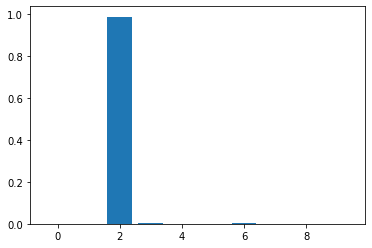

In [49]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

logits = ret[oname].flatten()
prob = softmax(logits)

plt.bar(np.arange(10), prob)

We see that the network correctly predicts this as a digit 2 with high probability. This concludes our tutorial on how to take a simple fully-connected BNN all the way down to hardware with FINN, and execute it remotely on a PYNQ board.